# Pipeline Optimization

For this exercise, we will have a look at Hyperparameter Optimization of ML
pipelines -- instead of optimizing a single component, we want to optimize the
entire ML approach, including any preprocessing etc. The end result (i.e. the
predictive performance) is not important; how you get there is.

Your deliverable will be a report, written in a style that it
would be suitable for inclusion in an academic paper as the "Experimental
Setup" section or similar. If unsure, check an academic paper of your choice,
for example [this one](https://www.eecs.uwyo.edu/~larsko/papers/pulatov_opening_2022-1.pdf). The
level of detail should be higher than in a typical academic paper though. Your
report should be at most five pages, including references and figures but
excluding appendices. It should have the following structure:
- Introduction: What problem are you solving, how are you going to solve it.
- Dataset Description: Describe the data you're using, e.g. how many features and observations, what are you predicting, any missing values, etc.
- Experimental Setup: What specifically are you doing to solve the problem, i.e. what programming languages and libraries, how are you processing the data, what preprocessing steps, machine learning algorithms, and other components are you considering and what hyperparameters and value ranges, what measures you are using to evaluate them, what hyperparameter optimization method you chose, etc.
- Results: Description of what you observed, including plots. Compare
  performance before and after tuning, and show the best configuration.
- Code: Add the code you've used as a separate file.

Your report must contain enough detail to reproduce what you did without the
code. If in doubt, include more detail.

There is no required format for the report. You could, for example, use an
iPython notebook.

## Data and Setup

Have a look at two different datasets. Ideally, they should have different
characteristics so that the results of your analysis will be different. You
could use, for example, the [Wine Quality dataset](https://archive-beta.ics.uci.edu/dataset/186/wine+quality)
(choose the type of wine of your preference) and the
[Primary Tumor dataset](https://www.openml.org/search?type=data&sort=runs&id=1003&status=active).
You may also use datasets of your choice, for example ones that are relevant to
your research.

Choose a small number of different machine learning algorithms and
hyperparameters, along with sensible value ranges, and additional ML pipeline
components. This could include, for example, a feature imputation step, a
feature recoding step, and an ensembling or stacking step in addition to the
learning algorithm. If those components have hyperparameters, you must choose
ranges and tune them as well. In addition, your pipeline should allow the
hyperparameter optimization to turn individual components on and off, e.g. use a
one-hot-encoding or not. Your hyperparameter search space should be so large
that you cannot simply run a grid search.

You can use implementations of AutoML systems (e.g. auto-sklearn), scientific
papers, or the documentation of the library you are using to determine the
hyperparameters to tune and the value ranges. Note that there is not only a
single way to do this, but define a reasonable space (e.g. don't include whether
to turn on debug output, or random forests with 1,000,000 trees, or tune the
loss function). Your ML pipeline needs to be reasonably complex, i.e. at least
three components.

Determine the best ML pipeline. Make sure to optimize the entire ML pipeline,
not individual parts individually. Choose a suitable hyperparameter optimizer;
you could also use several and e.g. compare the results achieved by random
search and Bayesian optimization. Make sure that the way you evaluate this
avoids bias and overfitting. You could use statistical tests to make this
determination.

## Submission

Add your report and code to this repository. Bonus points if you can set up a
Github action to automatically run the code and generate the report!


## Resources

- https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

## Global Variables

In [ ]:
RANDOM_STATE = 90
TEST_SPLIT_SIZE = 0.2
INNER_CV_SPLITS = 2
OUTER_CV_SPLITS = 5
BAYESIAN_OPTIMIZATION_ITERATIONS = 30
SCORING_METRIC = "f1_weighted"

## Functions

### Add to Parameter Dictionary

In [ ]:
def add_to_parameter_dictionary(parameter_dictionary: dict, isBayesianOptimization: bool, processing_step_name: str, processing_step_option: dict):

  if isBayesianOptimization:
    hp_dictionary = processing_step_option["bay_hyperparameters"]
  else:
    hp_dictionary = processing_step_option["hyperparameters"]

  if hp_dictionary is not None:
    for hp in hp_dictionary.keys():
      key_string = f"{processing_step_name}__{hp}"

      parameter_dictionary[key_string] = hp_dictionary[hp]

### Pipelines Creator

In [ ]:
from copy import deepcopy
from sklearn.pipeline import Pipeline

def add_step_to_pipeline_then_return_pipeline(pipes: list[dict], isBayesianOptimization: bool, processing_step: list, processing_step_name: str) -> list:

  pipelines = []

  for pipe in pipes:

    for option in processing_step:

      # If option is None, then the pre-processing step is skipped;

      pipe_copy = deepcopy(pipe)

      # Otherwise... the step is added:
      if option is not None:

        add_to_parameter_dictionary(
          parameter_dictionary=pipe_copy["parameters"],
          isBayesianOptimization=isBayesianOptimization,
          processing_step_name=processing_step_name,
          processing_step_option=option,
        )

        pipe_copy["pipeline"].steps.append(
            (processing_step_name, option["type"])
        )

      pipelines.append(pipe_copy)



  return pipelines

### K-fold CV

In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np


def k_fold_cross_validation(cv_splits: int, model, X:pd.DataFrame, y:pd.Series, scoring_metric: str) -> np.array:

  model_scores: np.array = cross_val_score(
      model,
      X,
      y,
      cv=cv_splits,
      scoring=scoring_metric,
  )

  return model_scores

### Bayesian Optimization - Nested Resampling Evaluation

In [ ]:
!pip install baytune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from baytune import BTBSession
from baytune.tuning import Tunable
import pandas as pd
import numpy as np

def nested_bayesian_optimization_model_evaluation(
    inner_splits: int,
    outer_splits: int,
    rand_state: int,
    iterations: int,
    X: pd.DataFrame,
    y: pd.Series,
    model,
    hp_space: dict,
    scoring_metric: str
) -> np.array:

  inner_fold = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=rand_state)
  outer_fold = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=rand_state)

  performance_estimates = []

  for train_index, test_index in outer_fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    def scoring_function(model_name, hyperparameter_values):
        model_instance = model.set_params(**hyperparameter_values)
        scores = cross_val_score(
            cv=inner_fold,
            estimator=model_instance,
            X=X_train,
            y=y_train,
            scoring=scoring_metric,
        )

        return scores.mean()

    tunables = {
        "pipeline" : Tunable(hp_space),
    }

    session = BTBSession(
        tunables=tunables,
        scorer=scoring_function,
        verbose=True,
    )

    best_result = session.run(BAYESIAN_OPTIMIZATION_ITERATIONS)

    best_model_name = best_result['name']
    hyperparameters = best_result['config']
    model_instance = model.set_params(**hyperparameters)

    model_instance.fit(X_train, y_train)

    score = model_instance.score(X_test, y_test)

    performance_estimates.append(score)

  performance_estimates = np.array(performance_estimates)

  return performance_estimates

### Bayesian Optimization - Hyperparameter Selection

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from baytune import BTBSession
from baytune.tuning import Tunable
import pandas as pd
import numpy as np

def bayesian_optimization_hp_selection(
    cv_splits: int,
    rand_state: int,
    iterations: int,
    X: pd.DataFrame,
    y: pd.Series,
    model,
    hp_space: dict,
    scoring_metric: str
) -> tuple:

  cv_fold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=rand_state)

  def scoring_function(model_name, hyperparameter_values):
      model_instance = model.set_params(**hyperparameter_values)
      scores = cross_val_score(
          cv=cv_fold,
          estimator=model_instance,
          X=X,
          y=y,
          scoring=scoring_metric,
      )

      return scores.mean()

  tunables = {
      "pipeline" : Tunable(hp_space),
  }

  session = BTBSession(
      tunables=tunables,
      scorer=scoring_function,
      verbose=True,
  )

  best_result = session.run(BAYESIAN_OPTIMIZATION_ITERATIONS)

  best_config = best_result['config']
  best_cv_score = best_result['score']
  model_name = best_result['name']

  return (model, best_config, best_cv_score)

## Import the Datasets

### Red Wine Quality Dataset

In [ ]:
import pandas as pd

red_wine_quality_df = pd.read_csv("winequality-red.csv", sep=';')

red_wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Primary Tumor Dataset

In [ ]:
from scipy.io import arff

primary_tumor_file = arff.loadarff('primary-tumor.arff')

primary_tumor_df = pd.DataFrame(primary_tumor_file[0])

for column in primary_tumor_df.columns:
  primary_tumor_df[column] = primary_tumor_df[column].str.decode('utf-8')

primary_tumor_df

,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal,binaryClass
0,>=60,female,?,?,no,no,no,no,no,yes,no,no,no,no,no,no,no,P
1,>=60,male,?,poorly,no,no,no,no,no,yes,no,no,no,yes,no,yes,no,P
2,30-59,female,adeno,?,no,no,no,yes,no,no,no,yes,no,no,yes,no,no,N
3,30-59,female,adeno,?,no,no,no,no,yes,no,no,no,no,no,no,no,no,N
4,30-59,female,adeno,?,no,no,no,yes,yes,no,no,no,no,no,no,no,no,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,30-59,female,adeno,well,no,no,no,no,yes,no,no,no,no,no,no,no,no,N
335,30-59,male,epidermoid,poorly,yes,no,no,no,no,no,no,yes,no,no,yes,no,no,P
336,30-59,female,adeno,well,no,no,no,yes,yes,no,no,no,no,no,no,no,no,N
337,30-59,female,adeno,?,yes,no,yes,yes,yes,yes,yes,no,no,no,no,no,yes,N


In [ ]:
primary_tumor_df = primary_tumor_df.replace({"?" : np.nan})

In [ ]:
primary_tumor_df

,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal,binaryClass
0,>=60,female,NaN,NaN,no,no,no,no,no,yes,no,no,no,no,no,no,no,P
1,>=60,male,NaN,poorly,no,no,no,no,no,yes,no,no,no,yes,no,yes,no,P
2,30-59,female,adeno,NaN,no,no,no,yes,no,no,no,yes,no,no,yes,no,no,N
3,30-59,female,adeno,NaN,no,no,no,no,yes,no,no,no,no,no,no,no,no,N
4,30-59,female,adeno,NaN,no,no,no,yes,yes,no,no,no,no,no,no,no,no,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,30-59,female,adeno,well,no,no,no,no,yes,no,no,no,no,no,no,no,no,N
335,30-59,male,epidermoid,poorly,yes,no,no,no,no,no,no,yes,no,no,yes,no,no,P
336,30-59,female,adeno,well,no,no,no,yes,yes,no,no,no,no,no,no,no,no,N
337,30-59,female,adeno,NaN,yes,no,yes,yes,yes,yes,yes,no,no,no,no,no,yes,N


## Pre-Processing Steps

### Scalers
- `StandardScaler()`
- `MinMaxScaler()`
- `RobustScaler()`
- `MaxAbsScaler()`
- `PowerTransformer()` with either "yeo-johnson" or "box-cox"
- `QuantileTransformer()` with either "uniform" or "normal"
- `Normalizer()`

In [ ]:
from baytune.tuning import hyperparams as hp
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    PowerTransformer,
    QuantileTransformer,
    Normalizer,
)

# "box-cox" hyperparamter for PowerTransformer() strictly requires positive values so it wont be a choice

scalers = [
    # {
    #     "type" : StandardScaler(),
    #     "hyperparameters" : None,
    #     "bay_hyperparameters" : None,
    # },
    # {
    #     "type" : MinMaxScaler(),
    #     "hyperparameters" : None,
    #     "bay_hyperparameters" : None,
    # },
    {
        "type" : RobustScaler(),
        "hyperparameters" : None,
        "bay_hyperparameters" : None,
    },
    # {
    #     "type" : MaxAbsScaler(),
    #     "hyperparameters" : None,
    #     "bay_hyperparameters" : None,
    # },
    # {
    #     "type" : PowerTransformer(),
    #     "hyperparameters" : None,
    #     "bay_hyperparameters" : None
    # },
    {
        "type" : QuantileTransformer(),
        "hyperparameters" : {
            "n_quantiles" : range(1, 1001),
            "output_distribution" : ["uniform", "normal"]
        },
        "bay_hyperparameters" : {
            "n_quantiles" : hp.IntHyperParam(min=1, max=1000, default=1000),
            "output_distribution" : hp.CategoricalHyperParam(choices=["uniform", "normal"], default="uniform")
        }
    },
    {
        "type" : Normalizer(),
        "hyperparameters" : {
            "norm" : ["l1", "l2", "max"],
        },
        "bay_hyperparameters" : {
            "norm" : hp.CategoricalHyperParam(choices=["l1", "l2", "max"], default="l2")
        }
    },
    None
]

### Imputers
- `SimpleImputer()` with different strategies
- `KNNImputer()` with different KNN hyper-parameters

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer
from baytune.tuning import hyperparams as hp

imputers = [
    {
        "type" : SimpleImputer(),
        "hyperparameters" : {
            "strategy" : ["mean", "median", "most_frequent"]
        },
        "bay_hyperparameters" : {
            "strategy" : hp.CategoricalHyperParam(choices=["mean", "median", "most_frequent"], default="mean"),
        }
    },
    # {
    #     "type" : KNNImputer(),
    #     "hyperparamters" : {
    #         "n_neighbors" : range(1, 101),
    #         "weights" : ["uniform", "distance"],
    #     },
    #     "bay_hyperparameters" : {
    #         "n_neighbors" : hp.IntHyperParam(min=1, max=100, default=5),
    #         "weights" : hp.CategoricalHyperParam(choices=["uniform", "distance"], default="uniform"),
    #     }
    # }
]

### Categorical Encoding
- `OrdinalEncoder()`
- `OneHotEncoder()`

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from baytune.tuning import hyperparams as hp

encoders = [
    {
        "type" : OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        "hyperparameters" : None,
        "bay_hyperparameters" : None,
    },
    {
        "type" : OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        "hyperparameters" : {
            "handle_unknown" : ["ignore", "infrequent_if_exist"]
        },
        "bay_hyperparameters" : {
            "handle_unknown" : hp.CategoricalHyperParam(choices=["ignore", "infrequent_if_exist"], default="ignore")
        },
    }
]

### Feature Selectors

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2
from baytune.tuning import hyperparams as hp

# default SelectPercentile function is f_classif

feature_selectors = [
    {
        "type" : SelectPercentile(),
        "bay_hyperparameters" : {
            "percentile" : hp.IntHyperParam(min=10, max=90, default=10)
        }
    },
    None
]

### Non-linear Transformers
- `PolynomialFeatures()`
- `SplineTransformer()`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from baytune.tuning import hyperparams as hp

# With SplineTransformer, degree < n_knots

non_linear_transformers = [
    {
        "type" : PolynomialFeatures(),
        "hyperparameters" : {
            "degree" : range(2, 6),
        },
        "bay_hyperparameters" : {
            "degree" :  hp.IntHyperParam(min=2, max=6, default=2),
        }
    },
    {
        "type" : SplineTransformer(),
        "hyperparameters" : {
            "degree" : range(2, 6),
            "n_knots" : range(6, 11),
            "knots" : ["uniform", "quantile"],
            "extrapolation" : ["constant", "linear", "continue", "periodic"]
        },
        "bay_hyperparameters" : {
            "degree" :  hp.IntHyperParam(min=2, max=6, default=3),
            "n_knots" : hp.IntHyperParam(min=6, max=11, default=6),
            "knots" : hp.CategoricalHyperParam(choices=["uniform", "quantile"], default="uniform"),
            "extrapolation" : hp.CategoricalHyperParam(choices=["constant", "linear", "continue", "periodic"], default="constant")
        }
    },
    None
]

## Machine Learning Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from baytune.tuning import hyperparams as hp

classifiers = [
    {
        "type" : SVC(probability=True, class_weight="balanced"),
        "hyperparameters": {
            "C" : uniform(loc=0.1, scale=100.0),
            "kernel": ["linear", "sigmoid", "rbf"],
            "degree": range(1, 51),
            "gamma" : ["scale", "auto"],
            "coef0" : uniform(loc=0.0, scale=1.0),
            "tol" : uniform(loc=0.001, scale=1.0),
        },
        "bay_hyperparameters" : {
            "C" : hp.FloatHyperParam(min=0.1, max=100, default=1.0),
            'kernel' : hp.CategoricalHyperParam(["linear", "rbf", "sigmoid"], default="rbf"),
            'degree' : hp.IntHyperParam(min=1, max=50, default=3),
            "gamma" : hp.CategoricalHyperParam(["scale", "auto"], default="scale"),
            "coef0" : hp.FloatHyperParam(min=0.0, max=1.0, default=0.0),
            "tol" : hp.FloatHyperParam(min=0.001, max=1.0, default=0.001),
        }
    },
    # {
    #     "type" : LogisticRegression(class_weight="balanced"),
    #     "hyperparameters" : {
    #         "solver" : ["lbfgs"],
    #         "penalty" : ["l2", None],
    #         "C" : uniform(loc=0.1, scale=1000.0),
    #         "max_iter" : range(100, 10001),
    #     },
    #     "bay_hyperparameters" : {
    #         'penalty': hp.CategoricalHyperParam(["l2", None], default="l2"),
    #         'C': hp.FloatHyperParam(min=0.1, max=1000, default=1.0),
    #         'solver': hp.CategoricalHyperParam(["lbfgs"], default="lbfgs"),
    #         'max_iter' : hp.IntHyperParam(min=100, max=10000, default=100),
    #     }
    # },
    {
        "type" : RandomForestClassifier(class_weight="balanced"),
        "hyperparameters" : {
            "n_estimators": range(50, 1001),
            "criterion": ['gini', 'entropy', 'log_loss'],
            "max_depth" : range(1, 101),
            "min_samples_split" : range(2, 101),
            "min_samples_leaf" : range(1, 101),
            "min_weight_fraction_leaf" : uniform(scale=0.5),
            "max_features" : ["sqrt", "log2", None],
        },
        "bay_hyperparameters" : {
            'n_estimators' : hp.IntHyperParam(min=50, max=1000, default=100),
            'criterion' : hp.CategoricalHyperParam(['gini', 'entropy', 'log_loss'], default='gini'),
            'max_depth': hp.IntHyperParam(min=1, max=100, default=5),
            'min_samples_split': hp.IntHyperParam(min=2, max=100, default=2),
            'min_samples_leaf': hp.IntHyperParam(min=1, max=100, default=1),
            'min_weight_fraction_leaf': hp.FloatHyperParam(min=0.0, max=0.5, default=0.0),
            'max_features': hp.CategoricalHyperParam(["sqrt", "log2", None], default='sqrt'),
        }
    },
]

## Primary Tumor

### Pipelines Creation

In [ ]:
from sklearn.pipeline import Pipeline

pt_pipeline = {
    "pipeline" : Pipeline(steps=[]),
    "parameters" : {},
}

pt_pipelines: list = add_step_to_pipeline_then_return_pipeline(
    pipes=[pt_pipeline],
    isBayesianOptimization=True,
    processing_step=encoders,
    processing_step_name="encoder"
)

pt_pipelines: list = add_step_to_pipeline_then_return_pipeline(
    pipes=pt_pipelines,
    isBayesianOptimization=True,
    processing_step=imputers,
    processing_step_name="imputer"
)

pt_pipelines = add_step_to_pipeline_then_return_pipeline(
    pipes=pt_pipelines,
    isBayesianOptimization=True,
    processing_step=scalers,
    processing_step_name="scaler"
)

pt_pipelines = add_step_to_pipeline_then_return_pipeline(
    pipes=pt_pipelines,
    isBayesianOptimization=True,
    processing_step=classifiers,
    processing_step_name="classifier"
)

print(len(pt_pipelines))

for pipeline in pt_pipelines:
  print(pipeline["parameters"])
  print(pipeline["pipeline"])
  print("******")

16
{'imputer__strategy': CategoricalHyperParam(choices=['mean', 'median', 'most_frequent'], default=mean), 'classifier__C': FloatHyperParam(min=0.1, max=100.0, default=1.0, include_min=True, include_max=True), 'classifier__kernel': CategoricalHyperParam(choices=['linear', 'rbf', 'sigmoid'], default=rbf), 'classifier__degree': IntHyperParam(min=1, max=50, default=3, include_min=True, include_max=True, step=1), 'classifier__gamma': CategoricalHyperParam(choices=['scale', 'auto'], default=scale), 'classifier__coef0': FloatHyperParam(min=0.0, max=1.0, default=0.0, include_min=True, include_max=True), 'classifier__tol': FloatHyperParam(min=0.001, max=1.0, default=0.001, include_min=True, include_max=True)}
Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer()), ('scaler', RobustScaler()),
                ('classifier', SVC(class_weight='balanced', probabi

### Dataset

In [ ]:
X = primary_tumor_df.iloc[:, :-1]
y = primary_tumor_df.iloc[:, -1]

### Nested Resampling Evaluation with Hyperparameter Optimization

In [ ]:
import numpy as np

pipelines_infos = []

for pipeline in pt_pipelines:

  bay_performance_estimates: np.array = nested_bayesian_optimization_model_evaluation(
    inner_splits=INNER_CV_SPLITS,
    outer_splits=OUTER_CV_SPLITS,
    rand_state=RANDOM_STATE,
    iterations=BAYESIAN_OPTIMIZATION_ITERATIONS,
    X=X,
    y=y,
    model=pipeline["pipeline"],
    hp_space=pipeline["parameters"],
    scoring_metric=SCORING_METRIC
  )

  pipelines_infos.append((pipeline["pipeline"], bay_performance_estimates))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (297) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (297) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (583) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (411) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (411) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (246) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (371) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (371) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (538) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (150) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (150) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (812) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (164) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (164) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (687) is greater than the total number of samples (136). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (480) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (480) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (785) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (944) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (944) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (644) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (769) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (769) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (166) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (710) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (710) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (748) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (490) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (490) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (793) is greater than the total number of samples (136). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The opti

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (259) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (259) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (725) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (859) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (859) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (397) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (606) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (606) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (162) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (881) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (881) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (725) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (156) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (156) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (861) is greater than the total number of samples (136). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (429) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (429) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (871) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (181) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (181) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (278) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (313) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (313) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (449) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (912) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (912) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (945) is greater than the total number of samples (135). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (653) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (653) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (887) is greater than the total number of samples (136). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
pipeline_scores = []

for pipeline_infos in pipelines_infos:

  pipeline_scores.append(pipeline_infos[1])

  print("***************************")
  print(pipeline_infos[0])
  print(f" PIPELINE PERFORMANCE ESTIMATE -> {round(pipeline_infos[1].mean(), 2)} +- {round(pipeline_infos[1].std(), 2)}")
  print("***************************")

***************************
Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer()), ('scaler', RobustScaler()),
                ('classifier', SVC(class_weight='balanced', probability=True))])
 PIPELINE PERFORMANCE ESTIMATE -> 0.85 +- 0.04
***************************
***************************
Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer()), ('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5))])
 PIPELINE PERFORMANCE ESTIMATE -> 0.86 +- 0.04
***************************
***************************
Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                u

<Axes: >

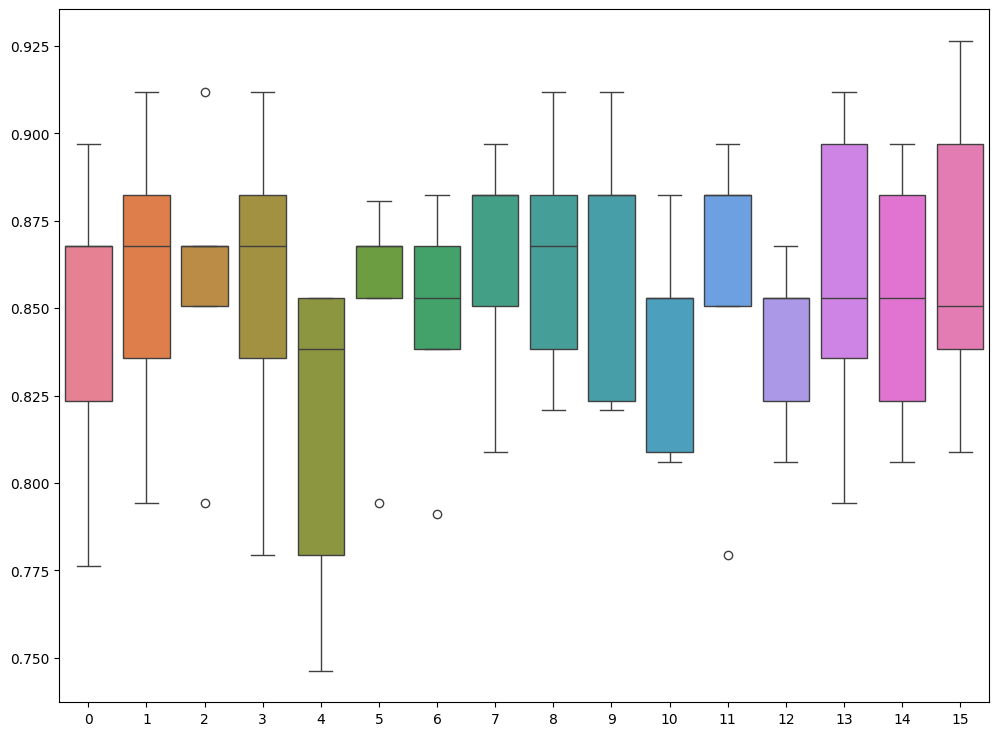

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))

sns.boxplot(data=pipeline_scores, ax=ax)

## Red Wine Quality

### Pipelines Creation

In [ ]:
from sklearn.pipeline import Pipeline

rw_pipeline = {
    "pipeline" : Pipeline(steps=[]),
    "parameters" : {},
}

rw_pipelines: list = add_step_to_pipeline_then_return_pipeline(
    pipes=[rw_pipeline],
    isBayesianOptimization=True,
    processing_step=scalers,
    processing_step_name="scaler"
)

rw_pipelines: list = add_step_to_pipeline_then_return_pipeline(
    pipes=rw_pipelines,
    isBayesianOptimization=True,
    processing_step=feature_selectors,
    processing_step_name="feature_selector"
)

rw_pipelines = add_step_to_pipeline_then_return_pipeline(
    pipes=rw_pipelines,
    isBayesianOptimization=True,
    processing_step=classifiers,
    processing_step_name="classifier"
)

print(len(rw_pipelines))

for pipeline in rw_pipelines:
  print(pipeline["parameters"])
  print(pipeline["pipeline"])
  print("******")

16
{'feature_selector__percentile': IntHyperParam(min=10, max=90, default=10, include_min=True, include_max=True, step=1), 'classifier__C': FloatHyperParam(min=0.1, max=100.0, default=1.0, include_min=True, include_max=True), 'classifier__kernel': CategoricalHyperParam(choices=['linear', 'rbf', 'sigmoid'], default=rbf), 'classifier__degree': IntHyperParam(min=1, max=50, default=3, include_min=True, include_max=True, step=1), 'classifier__gamma': CategoricalHyperParam(choices=['scale', 'auto'], default=scale), 'classifier__coef0': FloatHyperParam(min=0.0, max=1.0, default=0.0, include_min=True, include_max=True), 'classifier__tol': FloatHyperParam(min=0.001, max=1.0, default=0.001, include_min=True, include_max=True)}
Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selector', SelectPercentile()),
                ('classifier', SVC(class_weight='balanced', probability=True))])
******
{'feature_selector__percentile': IntHyperParam(min=10, max=90, default=10, include_

### Dataset

In [ ]:
X = red_wine_quality_df.iloc[:, :-1]
y = red_wine_quality_df.iloc[:, -1]

### Nested Resampling Evaluation with Hyperparameter Optimization

In [ ]:
import numpy as np

pipelines_infos = []

for pipeline in rw_pipelines:

  bay_performance_estimates: np.array = nested_bayesian_optimization_model_evaluation(
    inner_splits=INNER_CV_SPLITS,
    outer_splits=OUTER_CV_SPLITS,
    rand_state=RANDOM_STATE,
    iterations=BAYESIAN_OPTIMIZATION_ITERATIONS,
    X=X,
    y=y,
    model=pipeline["pipeline"],
    hp_space=pipeline["parameters"],
    scoring_metric=SCORING_METRIC
  )

  pipelines_infos.append((pipeline["pipeline"], bay_performance_estimates))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (968) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (968) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (719) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (735) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (735) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (717) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (717) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (701) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (924) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (924) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (792) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (935) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (935) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (682) is greater than the total number of samples (640). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (869) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (869) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (763) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (721) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (721) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (781) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (667) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (667) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (915) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (716) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (716) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (877) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (840) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (840) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (798) is greater than the total number of samples (640). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (670) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (670) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (996) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (727) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (727) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (845) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (705) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (705) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (673) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (938) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (938) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (760) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (873) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (873) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (998) is greater than the total number of samples (640). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (922) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (922) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (910) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (819) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (819) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (728) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (682) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (682) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (999) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (893) is greater than the total number of samples (639). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (893) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (724) is greater than the total number of samples (639). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (719) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (719) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (862) is greater than the total number of samples (640). n_q

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
pipeline_scores = []

for pipeline_infos in pipelines_infos:

  pipeline_scores.append(pipeline_infos[1])

  print("***************************")
  print(pipeline_infos[0])
  print(f" PIPELINE PERFORMANCE ESTIMATE -> {round(pipeline_infos[1].mean(), 2)} +- {round(pipeline_infos[1].std(), 2)}")
  print("***************************")

***************************
Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selector', SelectPercentile(percentile=87)),
                ('classifier',
                 SVC(C=52.13069874347775, class_weight='balanced',
                     coef0=0.9167043344385742, degree=22, gamma='auto',
                     probability=True, tol=0.6430459264098866))])
 PIPELINE PERFORMANCE ESTIMATE -> 0.57 +- 0.03
***************************
***************************
Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selector', SelectPercentile(percentile=19)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=5, min_samples_split=9,
                                        min_weight_fraction_leaf=0.007133517440573611,
                                        n_estimators=200))])
 PIPELINE PERFORMANCE ESTIMATE -> 0.52 +- 0.02
*****************

<Axes: >

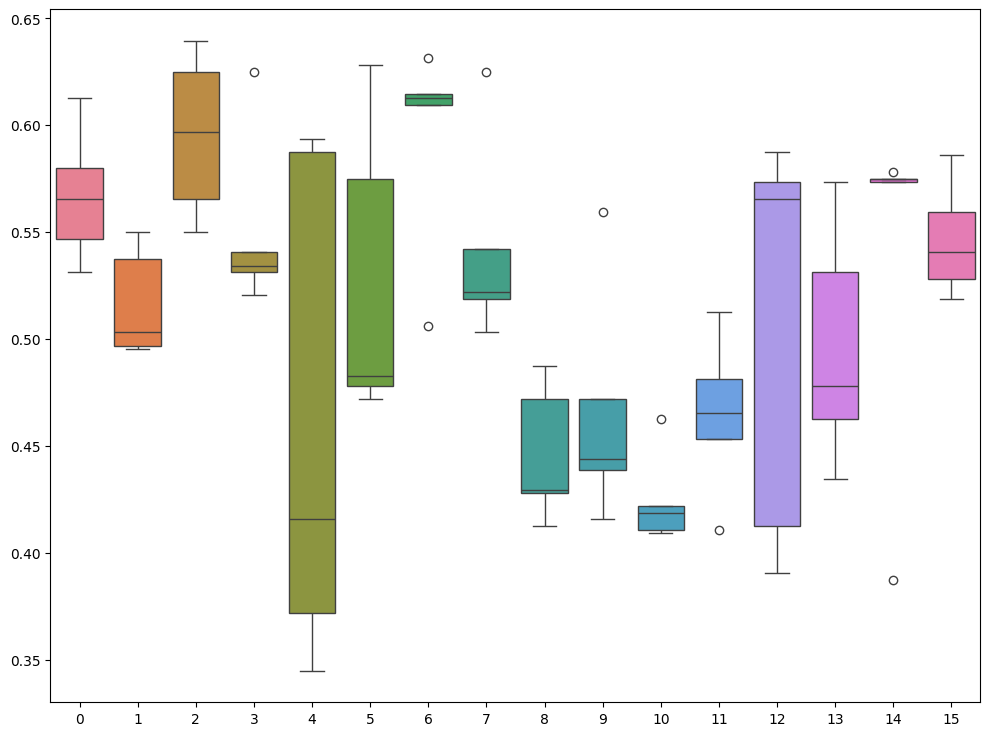

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))

sns.boxplot(data=pipeline_scores, ax=ax)